In [1]:
# Generic inputs for most ML tasks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import datetime


from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.ensemble import HistGradientBoostingRegressor
import xgboost as xgb

pd.options.display.float_format = '{:,.2f}'.format

# setup interactive notebook mode
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, HTML

# Initialize lists to collect model performance
model_names = []
model_maes = []
model_mabs = []

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

# Read, pre-process and visualize data

In [2]:
data_set = pd.read_csv('1.csv')
data_set.head()
data_set.tail()

,Date,SP500,Futures,Nikkei,FTSE,DAX
0,04/03/19,"2,873.40","2,879.75","21,713.21","7,418.28","11,954.40"
1,04/04/19,"2,879.39","2,882.75","21,724.95","7,401.94","11,988.01"
2,04/05/19,"2,892.74","2,896.00","21,807.50","7,446.87","12,009.75"
3,04/08/19,"2,895.77","2,898.25","21,761.65","7,451.89","11,963.40"
4,04/09/19,"2,878.20","2,882.50","21,802.59","7,425.57","11,850.57"


,Date,SP500,Futures,Nikkei,FTSE,DAX
1511,04/07/25,"5,062.25","5,149.75","31,136.58","7,702.08","19,789.62"
1512,04/08/25,"4,982.77","5,020.25","33,012.58","7,910.53","20,280.26"
1513,04/09/25,"5,456.90","5,491.00","31,714.03","7,679.48","19,670.88"
1514,04/10/25,"5,268.05","5,302.00","34,609.00","7,913.25","20,562.73"
1515,04/11/25,"5,363.36","5,391.25","33,585.58","7,964.18","20,374.10"


In [3]:
len(data_set)
data_set.isna().sum()
data_set.dtypes

1516

Date        0
SP500       0
Futures     0
Nikkei     98
FTSE       30
DAX        24
dtype: int64

Date        object
SP500      float64
Futures    float64
Nikkei     float64
FTSE       float64
DAX        float64
dtype: object

In [4]:
data_set.columns

# Step 1: Convert to datetime
data_set['Date'] = pd.to_datetime(data_set['Date'])

# ✅ Step 2: Extract day of week
data_set['day_of_week'] = data_set['Date'].dt.dayofweek  # 0=Mon, ..., 6=Sun

# Step 3 (optional): If you still want UNIX timestamp
data_set['Date'] = data_set['Date'].astype(np.int64) // 10**9

data_set.tail()

Index(['Date', 'SP500', 'Futures', 'Nikkei', 'FTSE', 'DAX'], dtype='object')

C:\Users\rajni\AppData\Local\Temp\ipykernel_31908\866144551.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_set['Date'] = pd.to_datetime(data_set['Date'])


,Date,SP500,Futures,Nikkei,FTSE,DAX,day_of_week
1511,1743984000,"5,062.25","5,149.75","31,136.58","7,702.08","19,789.62",0
1512,1744070400,"4,982.77","5,020.25","33,012.58","7,910.53","20,280.26",1
1513,1744156800,"5,456.90","5,491.00","31,714.03","7,679.48","19,670.88",2
1514,1744243200,"5,268.05","5,302.00","34,609.00","7,913.25","20,562.73",3
1515,1744329600,"5,363.36","5,391.25","33,585.58","7,964.18","20,374.10",4


In [5]:
# Reshape to 2D as required by OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
day_of_week_encoded = encoder.fit_transform(data_set[['day_of_week']])

In [6]:
# Get feature names like ['day_of_week_0', 'day_of_week_1', ...]
encoded_cols = encoder.get_feature_names_out(['day_of_week'])
encoded_df = pd.DataFrame(day_of_week_encoded, columns=encoded_cols, index=data_set.index)
data_set = pd.concat([data_set.drop(columns=['day_of_week']), encoded_df], axis=1)

In [7]:
def add_lag_features(df, columns, lags):
    """
    Adds lag features for given columns and lag days.

    Parameters:
    df (pd.DataFrame): Original dataset
    columns (list): Columns for which to create lag features
    lags (list): List of lag values (e.g., [1, 2, 3])

    Returns:
    pd.DataFrame: Dataset with new lag features
    """
    for col in columns:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df


lag_columns = ['SP500', 'DAX', 'FTSE', 'Nikkei']
lag_days = [1, 2, 3] 

data_set = add_lag_features(data_set, lag_columns, lag_days)
data_set = data_set.dropna()  # Drop rows with NaNs from lags
data_set.head()


data_set = data_set.sort_values(by='Date').reset_index(drop=True)



,Date,SP500,Futures,Nikkei,FTSE,DAX,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,...,SP500_lag_3,DAX_lag_1,DAX_lag_2,DAX_lag_3,FTSE_lag_1,FTSE_lag_2,FTSE_lag_3,Nikkei_lag_1,Nikkei_lag_2,Nikkei_lag_3
3,1554681600,"2,895.77","2,898.25","21,761.65","7,451.89","11,963.40",1.00,0.00,0.00,0.00,...,"2,873.40","12,009.75","11,988.01","11,954.40","7,446.87","7,401.94","7,418.28","21,807.50","21,724.95","21,713.21"
4,1554768000,"2,878.20","2,882.50","21,802.59","7,425.57","11,850.57",0.00,1.00,0.00,0.00,...,"2,879.39","11,963.40","12,009.75","11,988.01","7,451.89","7,446.87","7,401.94","21,761.65","21,807.50","21,724.95"
5,1554854400,"2,888.21","2,894.50","21,687.57","7,421.91","11,905.91",0.00,0.00,1.00,0.00,...,"2,892.74","11,850.57","11,963.40","12,009.75","7,425.57","7,451.89","7,446.87","21,802.59","21,761.65","21,807.50"
6,1554940800,"2,888.32","2,891.75","21,711.38","7,417.95","11,935.20",0.00,0.00,0.00,1.00,...,"2,895.77","11,905.91","11,850.57","11,963.40","7,421.91","7,425.57","7,451.89","21,687.57","21,802.59","21,761.65"
7,1555027200,"2,907.41","2,912.50","21,870.56","7,437.06","11,999.93",0.00,0.00,0.00,0.00,...,"2,878.20","11,935.20","11,905.91","11,850.57","7,417.95","7,421.91","7,425.57","21,711.38","21,687.57","21,802.59"


In [8]:
data_set['SP500_next'] = data_set['SP500'].shift(-1)
data_set = data_set.dropna()

In [9]:

# Parameters for sliding window
window_size = 10
train_size = 8
test_size = 2

X_full = data_set.drop(columns=['SP500_next'])
y_full = data_set['SP500_next']

# Containers to hold concatenated training and testing data
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

# Sliding window generation
for start in range(0, len(X_full) - window_size + 1, test_size):  # step by test size
    end = start + window_size
    X_window = X_full.iloc[start:end]
    y_window = y_full.iloc[start:end]
    
    X_train_list.append(X_window.iloc[:train_size])
    y_train_list.append(y_window.iloc[:train_size])
    X_test_list.append(X_window.iloc[train_size:])
    y_test_list.append(y_window.iloc[train_size:])

# Concatenate all windows together to get final train-test sets
X_train = pd.concat(X_train_list, ignore_index=True)
y_train = pd.concat(y_train_list, ignore_index=True)
X_test = pd.concat(X_test_list, ignore_index=True)
y_test = pd.concat(y_test_list, ignore_index=True)


# Decison tree


In [10]:
clf = DecisionTreeRegressor(random_state=50)

clf = clf.fit(X_train, y_train) 

In [11]:
X_train.columns
clf.feature_importances_

Index(['Date', 'SP500', 'Futures', 'Nikkei', 'FTSE', 'DAX', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'SP500_lag_1', 'SP500_lag_2', 'SP500_lag_3', 'DAX_lag_1', 'DAX_lag_2',
       'DAX_lag_3', 'FTSE_lag_1', 'FTSE_lag_2', 'FTSE_lag_3', 'Nikkei_lag_1',
       'Nikkei_lag_2', 'Nikkei_lag_3'],
      dtype='object')

array([1.57487557e-01, 8.23976612e-01, 1.41091255e-02, 1.52509213e-04,
       5.64268314e-04, 1.80076426e-04, 1.06134936e-05, 8.53822522e-06,
       1.04791770e-05, 3.57577758e-05, 1.07300027e-05, 1.12102159e-04,
       1.71861952e-03, 1.66857646e-04, 9.26134516e-05, 2.06267101e-04,
       1.19535221e-04, 1.05680021e-04, 1.29540092e-04, 1.98329428e-04,
       1.70665691e-04, 2.77686603e-04, 1.55835899e-04])

In [12]:
test_output = pd.DataFrame(clf.predict(X_test), index = X_test.index, columns = ['pred_SP500_next'])
test_output = test_output.merge(y_test, left_index = True, right_index = True)
test_output.head()
mean_absolute_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean()
print('Mean absolute error is ')
print(mean_absolute_error)
mean_absolute_percentage_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean() / test_output['SP500_next'].mean()
print('Mean absolute percentage error is ')
print(mean_absolute_percentage_error)

model_names.append("Decision Tree")
model_maes.append(mean_absolute_error)
model_mabs.append(mean_absolute_percentage_error)

,pred_SP500_next,SP500_next
0,"2,939.88","2,939.88"
1,"2,881.40","2,881.40"
2,"2,811.87","2,811.87"
3,"2,834.41","2,834.41"
4,"2,850.96","2,850.96"


Mean absolute error is 
0.3915229357798159
Mean absolute percentage error is 
9.322625555003514e-05


In [13]:
clf.score(X_train,y_train)

clf.score(X_test, y_test) 


1.0

0.9998796361376285

## Bagging Regressor ## 

In [14]:
regr = BaggingRegressor(random_state=50, n_estimators = 200, max_samples = 800)

regr = regr.fit(X_train, y_train) 

In [15]:
test_output = pd.DataFrame(regr.predict(X_test), index = X_test.index, columns = ['pred_SP500_next'])
test_output = test_output.merge(y_test, left_index = True, right_index = True)
test_output.head()
mean_absolute_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean()
print('Mean absolute error is ')
print(mean_absolute_error)
mean_absolute_percentage_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean() / test_output['SP500_next'].mean()
print('Mean absolute percentage error is ')
print(mean_absolute_percentage_error)

model_names.append("Bagging Regressor")
model_maes.append(mean_absolute_error)
model_mabs.append(mean_absolute_percentage_error)

,pred_SP500_next,SP500_next
0,"2,916.51","2,939.88"
1,"2,908.90","2,881.40"
2,"2,848.42","2,811.87"
3,"2,833.14","2,834.41"
4,"2,844.37","2,850.96"


Mean absolute error is 
20.060283532109906
Mean absolute percentage error is 
0.0047765914792342315


In [16]:
regr.score(X_train, y_train)
regr.score(X_test, y_test) 


0.9989249025697496

0.9986956814818583

## Random Forest Regressor 

In [17]:
rf = RandomForestRegressor(random_state=50, min_samples_leaf = 3, max_features = "sqrt")

rf = rf.fit(X_train, y_train) 


In [18]:
X_train.columns
rf.feature_importances_

Index(['Date', 'SP500', 'Futures', 'Nikkei', 'FTSE', 'DAX', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'SP500_lag_1', 'SP500_lag_2', 'SP500_lag_3', 'DAX_lag_1', 'DAX_lag_2',
       'DAX_lag_3', 'FTSE_lag_1', 'FTSE_lag_2', 'FTSE_lag_3', 'Nikkei_lag_1',
       'Nikkei_lag_2', 'Nikkei_lag_3'],
      dtype='object')

array([7.39563736e-02, 1.84166976e-01, 1.33676699e-01, 2.22920221e-02,
       1.01910217e-02, 2.55057331e-02, 1.59937246e-05, 1.66053718e-05,
       2.71173391e-05, 2.67892105e-05, 3.04044255e-05, 8.91401284e-02,
       1.41864867e-01, 7.42484816e-02, 4.00551979e-02, 6.66492347e-02,
       2.34434616e-02, 9.01585985e-03, 4.98187523e-03, 1.54739169e-03,
       3.16293280e-02, 3.71970423e-02, 3.03213962e-02])

In [19]:
test_output = pd.DataFrame(rf.predict(X_test), index = X_test.index, columns = ['pred_SP500_next'])
test_output = test_output.merge(y_test, left_index = True, right_index = True)
test_output.head()
mean_absolute_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean()
print('Mean absolute error is ')
print(mean_absolute_error)
mean_absolute_percentage_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean() / test_output['SP500_next'].mean()
print('Mean absolute percentage error is ')
print(mean_absolute_percentage_error)

model_names.append("Random Forest Regressor")
model_maes.append(mean_absolute_error)
model_mabs.append(mean_absolute_percentage_error)

,pred_SP500_next,SP500_next
0,"2,934.65","2,939.88"
1,"2,887.60","2,881.40"
2,"2,824.58","2,811.87"
3,"2,834.59","2,834.41"
4,"2,849.03","2,850.96"


Mean absolute error is 
5.713814112445182
Mean absolute percentage error is 
0.0013605269217530035


In [20]:
rf.score(X_train,y_train)
rf.score(X_test, y_test) 


0.9998613544866495

0.9997273605228968

## Gradeint Boosting Regressor

In [21]:
gb = GradientBoostingRegressor(random_state=50, min_samples_leaf = 2, max_depth = 4)

gb = gb.fit(X_train, y_train) 


In [22]:
X_train.columns
gb.feature_importances_

Index(['Date', 'SP500', 'Futures', 'Nikkei', 'FTSE', 'DAX', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'SP500_lag_1', 'SP500_lag_2', 'SP500_lag_3', 'DAX_lag_1', 'DAX_lag_2',
       'DAX_lag_3', 'FTSE_lag_1', 'FTSE_lag_2', 'FTSE_lag_3', 'Nikkei_lag_1',
       'Nikkei_lag_2', 'Nikkei_lag_3'],
      dtype='object')

array([7.97310203e-02, 5.99006288e-01, 2.14871286e-01, 4.16690478e-04,
       3.58762999e-03, 3.65048987e-04, 8.14738096e-07, 2.22538877e-06,
       3.35399529e-06, 3.25737417e-06, 4.40727740e-06, 2.77457512e-02,
       3.65748053e-02, 8.89186702e-03, 6.20073613e-04, 7.96189478e-03,
       1.74394065e-02, 7.47217763e-05, 1.37037895e-04, 1.63865881e-03,
       2.19237333e-04, 2.12602259e-04, 4.91920771e-04])

In [23]:
test_output = pd.DataFrame(gb.predict(X_test), index = X_test.index, columns = ['pred_SP500_next'])
test_output = test_output.merge(y_test, left_index = True, right_index = True)
test_output.head()
mean_absolute_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean()
print('Mean absolute error is ')
print(mean_absolute_error)
mean_absolute_percentage_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean() / test_output['SP500_next'].mean()
print('Mean absolute percentage error is ')
print(mean_absolute_percentage_error)

model_names.append("Gradeint Boosting Regressor")
model_maes.append(mean_absolute_error)
model_mabs.append(mean_absolute_percentage_error)

,pred_SP500_next,SP500_next
0,"2,921.29","2,939.88"
1,"2,907.24","2,881.40"
2,"2,837.42","2,811.87"
3,"2,829.06","2,834.41"
4,"2,854.80","2,850.96"


Mean absolute error is 
21.878776718009725
Mean absolute percentage error is 
0.005209596279137026


In [24]:
gb.score(X_train,y_train)
gb.score(X_test, y_test) 


0.9989735608294674

0.9988969048337569

## XGBoost Regressor 

In [25]:
# XGBoost comes with its own class for storing datasets called DMatrix. 
# It is a highly optimized class for memory and speed. 
# That's why converting datasets into this format is a requirement for the native XGBoost API:


# Create regression matrices

dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)

dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [26]:
params = {"objective": "reg:squarederror", "tree_method": "exact", "max_depth" : 4, "learning_rate" : 0.1} # use "tree_method" : "hist" if you need speed

In [27]:
n = 100

model = xgb.train(
   params=params,

   dtrain=dtrain_reg,

   num_boost_round=n,

)

In [28]:
from sklearn.metrics import mean_squared_error
preds = model.predict(dtest_reg)


In [29]:
test_output = pd.DataFrame(preds, index = X_test.index, columns = ['pred_SP500_next'])
test_output = test_output.merge(y_test, left_index = True, right_index = True)
test_output.head()
mean_absolute_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean()
print('Mean absolute error is ')
print(mean_absolute_error)
mean_absolute_percentage_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean() / test_output['SP500_next'].mean()
print('Mean absolute percentage error is ')
print(mean_absolute_percentage_error)

model_names.append("XGBoost Regressor")
model_maes.append(mean_absolute_error)
model_mabs.append(mean_absolute_percentage_error)

,pred_SP500_next,SP500_next
0,"2,919.36","2,939.88"
1,"2,910.66","2,881.40"
2,"2,843.86","2,811.87"
3,"2,826.23","2,834.41"
4,"2,850.05","2,850.96"


Mean absolute error is 
22.635254793219623
Mean absolute percentage error is 
0.005389722682758952


In [30]:
from sklearn.metrics import r2_score

# Predict on training and test sets
train_preds = model.predict(dtrain_reg)
test_preds = model.predict(dtest_reg)

# R² score for training set
train_r2 = r2_score(y_train, train_preds)
print(f"R² score on training set: {train_r2:.4f}")

# R² score for test set
test_r2 = r2_score(y_test, test_preds)
print(f"R² score on test set: {test_r2:.4f}")

R² score on training set: 0.9989
R² score on test set: 0.9988


## Hybrid Model 

In [31]:
model = LinearRegression(fit_intercept = True)
model.fit(X_train, y_train) 

# The following gives the R-square score
model.score(X_train, y_train) 

LinearRegression()

0.9961064736455846

In [32]:
training_residuals = y_train - model.predict(X_train)

In [33]:
rf = RandomForestRegressor(random_state=50, min_samples_leaf = 3, max_features = "sqrt")

rf = rf.fit(X_train, training_residuals) 

In [34]:
pred_residuals = rf.predict(X_test)
y_pred = pred_residuals + model.predict(X_test)

In [35]:
test_output = pd.DataFrame(y_pred, index = X_test.index, columns = ['pred_SP500_next'])
test_output = test_output.merge(y_test, left_index = True, right_index = True)
test_output.head()
mean_absolute_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean()
print('Mean absolute error is ')
print(mean_absolute_error)
mean_absolute_percentage_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean() / test_output['SP500_next'].mean()
print('Mean absolute percentage error is ')
print(mean_absolute_percentage_error)

model_names.append("Hybrid Model")
model_maes.append(mean_absolute_error)
model_mabs.append(mean_absolute_percentage_error)

,pred_SP500_next,SP500_next
0,"2,934.35","2,939.88"
1,"2,888.94","2,881.40"
2,"2,828.66","2,811.87"
3,"2,831.83","2,834.41"
4,"2,848.78","2,850.96"


Mean absolute error is 
5.623416887528533
Mean absolute percentage error is 
0.001339002270140172


In [36]:
from sklearn.metrics import r2_score

# Training R²
train_hybrid_pred = model.predict(X_train) + rf.predict(X_train)
hybrid_r2_train = r2_score(y_train, train_hybrid_pred)
print(f"Hybrid Model R² score on training set: {hybrid_r2_train:.4f}")

# Test R² (y_pred is already calculated above)
hybrid_r2_test = r2_score(y_test, y_pred)
print(f"Hybrid Model R² score on test set: {hybrid_r2_test:.4f}")


Hybrid Model R² score on training set: 0.9998
Hybrid Model R² score on test set: 0.9997


# Hybrid (XGBoost)

In [37]:
# XGBoost on residuals
dtrain_resid = xgb.DMatrix(X_train, label=training_residuals, enable_categorical=True)
dtest_resid = xgb.DMatrix(X_test, enable_categorical=True)

In [38]:
params = {"objective": "reg:squarederror", "tree_method": "exact", "max_depth" : 4, "learning_rate" : 0.1} # use "tree_method" : "hist" if you need speed
num_round = 100

In [39]:
residual_model = xgb.train(params, dtrain_resid, num_boost_round=num_round)

# Predict residuals on test set using XGBoost
pred_residuals = residual_model.predict(dtest_resid)

# Final hybrid prediction = linear prediction + xgboost residual prediction
yy_pred = model.predict(X_test) + pred_residuals

In [40]:
test_output = pd.DataFrame(yy_pred, index = X_test.index, columns = ['pred_SP500_next'])
test_output = test_output.merge(y_test, left_index = True, right_index = True)
test_output.head()
mean_absolute_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean()
print('Mean absolute error is ')
print(mean_absolute_error)
mean_absolute_percentage_error = abs(test_output['pred_SP500_next'] - test_output['SP500_next']).mean() / test_output['SP500_next'].mean()
print('Mean absolute percentage error is ')
print(mean_absolute_percentage_error)

model_names.append("Hybrid (XGBoost)")
model_maes.append(mean_absolute_error)
model_mabs.append(mean_absolute_percentage_error)

,pred_SP500_next,SP500_next
0,"2,915.63","2,939.88"
1,"2,904.78","2,881.40"
2,"2,864.72","2,811.87"
3,"2,829.91","2,834.41"
4,"2,841.24","2,850.96"


Mean absolute error is 
27.236883899786452
Mean absolute percentage error is 
0.006485425161033521


In [41]:
from sklearn.metrics import r2_score

# R² score on test set
r2_test = r2_score(y_test, yy_pred)
print(f"Hybrid (XGBoost) Model R² score on test set: {r2_test:.4f}")

# R² score on training set
train_linear_pred = model.predict(X_train)
train_xgb_resid_pred = residual_model.predict(dtrain_resid)
train_hybrid_pred = train_linear_pred + train_xgb_resid_pred

r2_train = r2_score(y_train, train_hybrid_pred)
print(f"Hybrid (XGBoost) Model R² score on training set: {r2_train:.4f}")

Hybrid (XGBoost) Model R² score on test set: 0.9981
Hybrid (XGBoost) Model R² score on training set: 0.9985


## Plotting a Graph for Comparing Results


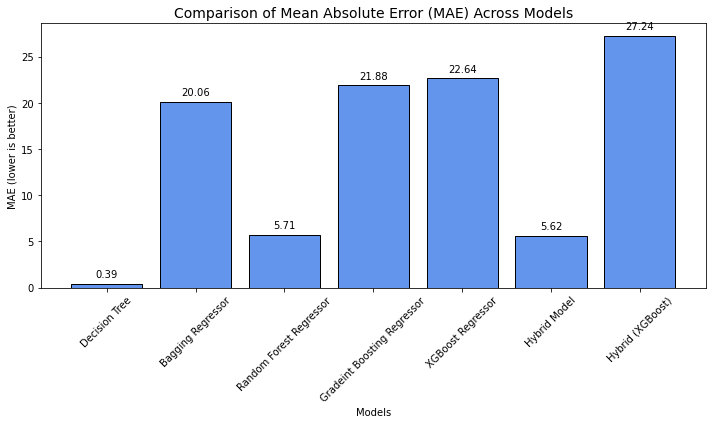

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({'Model': model_names, 'MAE': model_maes})

plt.figure(figsize=(10, 6))
bars = plt.bar(df['Model'], df['MAE'], color='cornflowerblue', edgecolor='black')
plt.title('Comparison of Mean Absolute Error (MAE) Across Models', fontsize=14)
plt.xlabel('Models')
plt.ylabel('MAE (lower is better)')
plt.xticks(rotation=45)

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show();


# Plotting a Graph using MAPE

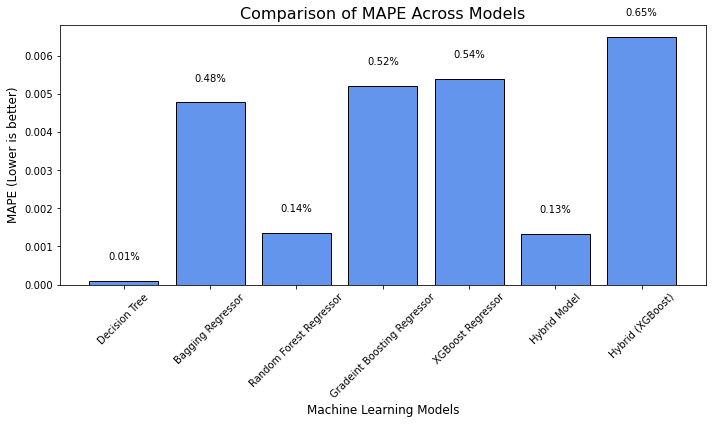

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# Create DataFrame with model names and MAPE values
df = pd.DataFrame({'Model': model_names, 'MAPE': model_mabs})

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar(df['Model'], df['MAPE'], color='cornflowerblue', edgecolor='black')

# Add title and axis labels
plt.title('Comparison of MAPE Across Models', fontsize=16)
plt.xlabel('Machine Learning Models', fontsize=12)
plt.ylabel('MAPE (Lower is better)', fontsize=12)
plt.xticks(rotation=45)

# Annotate each bar with its height (as percentage)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.0005, f"{yval:.2%}", 
             ha='center', va='bottom', fontsize=10)

# Improve layout
plt.tight_layout()
plt.show();


In [44]:
# Assume "data_set" is your original DataFrame that was used to train the model.
# Use the very last row of data_set as the base (last complete known day)
last_known = data_set.iloc[-1].copy()


# Prepare lists to store predictions and their corresponding dates
predictions = []
future_dates = []

# Define the number of future days to predict (3 in this case)
n_future = 3

# Function to simulate future feature changes.
# You can modify step and noise_scale to reflect your assumptions.
def uptrend(x, step=0.002, noise_scale=0.001):
    trend = x * (1 + step)  # Increase instead of decrease
    noise = x * np.random.normal(0, noise_scale)  # Add small random fluctuation
    return trend + noise

In [45]:
# (Optional) Function to generate day-of-week encoded features based on a date.
# Adjust column names as per your training data if needed.
def generate_day_of_week_features(date):
    day = date.weekday()  # Monday=0, Sunday=6
    features = {
        'day_of_week_0': 1 if day == 0 else 0,
        'day_of_week_1': 1 if day == 1 else 0,
        'day_of_week_2': 1 if day == 2 else 0,
        'day_of_week_3': 1 if day == 3 else 0,
        'day_of_week_4': 1 if day == 4 else 0,
    }
    return features

# Set a start date for predictions (for example, tomorrow's date)
start_date = datetime.date.today() + datetime.timedelta(days=1)

# List to store the future simulation rows (each as a DataFrame row)
future_rows = []


# Hybrid Model Next 3 days

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Predicted S&P500 for Next 3 Days')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Predicted S&P500')

(array([20193.  , 20193.25, 20193.5 , 20193.75, 20194.  , 20194.25,
        20194.5 , 20194.75, 20195.  ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

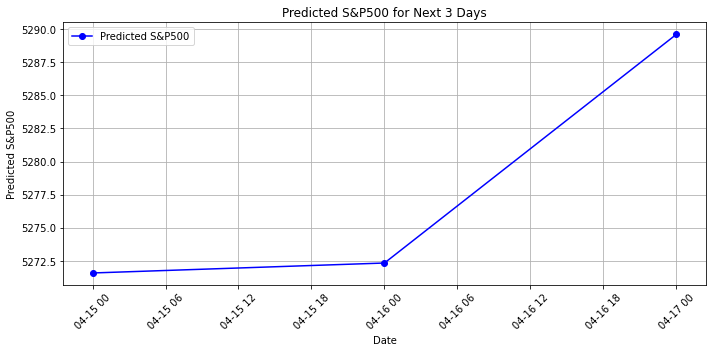

2025-04-15: Predicted S&P500 = 5271.58
2025-04-16: Predicted S&P500 = 5272.33
2025-04-17: Predicted S&P500 = 5289.61


In [46]:
# Iteratively generate predictions for n_future days
for i in range(n_future):
    # Determine the future date for this prediction
    future_date = start_date + datetime.timedelta(days=i)
    future_dates.append(future_date)
    
    # Create a new input row based on the last known row
    input_dict = {
        # For date features, you might want to store a timestamp or the date itself.
        # Here we simulate a Unix timestamp.
        'Date': int(datetime.datetime.combine(future_date, datetime.time()).timestamp()),
        
        # Use the last known or simulated values for the predictors:
        'SP500': last_known['SP500'],   # Note: This will be replaced by our prediction
        'Futures': last_known['Futures'],
        'Nikkei': last_known['Nikkei'],
        'FTSE': last_known['FTSE'],
        'DAX': last_known['DAX'],
        
        # Lag features (make sure these match what you used during training)
        'SP500_lag_1': last_known['SP500_lag_1'],
        'SP500_lag_2': last_known['SP500_lag_2'],
        'SP500_lag_3': last_known['SP500_lag_3'],
        'DAX_lag_1': last_known['DAX_lag_1'],
        'DAX_lag_2': last_known['DAX_lag_2'],
        'DAX_lag_3': last_known['DAX_lag_3'],
        'FTSE_lag_1': last_known['FTSE_lag_1'],
        'FTSE_lag_2': last_known['FTSE_lag_2'],
        'FTSE_lag_3': last_known['FTSE_lag_3'],
        'Nikkei_lag_1': last_known['Nikkei_lag_1'],
        'Nikkei_lag_2': last_known['Nikkei_lag_2'],
        'Nikkei_lag_3': last_known['Nikkei_lag_3']
    }
    
    # (Optional) Update/Generate day-of-week features from the future date
    input_dict.update(generate_day_of_week_features(future_date))
    
    # Convert the dictionary to DataFrame, ensuring it has one row
    input_df = pd.DataFrame([input_dict])
    
    # IMPORTANT: Align the input DataFrame with the features the model was trained on.
    # This is done by checking model.feature_names_in_ and adding any missing columns.
    required_features = model.feature_names_in_
    for col in required_features:
        if col not in input_df.columns:
            input_df[col] = 0.0
    input_df = input_df[required_features]
    
    # Make prediction using the trained hybrid model.
    # If you are using a hybrid model (i.e. base + residual correction), then do:
    # hybrid_pred = model.predict(input_df)[0] + residual_model.predict(input_df)[0]
    # Otherwise, if you're using a single model:
    pred = model.predict(input_df)[0]
    
    # If using the hybrid, uncomment the next two lines and comment out the above one:
    # linear_pred = model.predict(input_df)[0]
    # residual_pred = rf.predict(input_df)[0]
    # hybrid_pred = linear_pred + residual_pred
    # pred = hybrid_pred
    
    predictions.append(pred)
    
    # Now update the last_known row for recursive forecasting:
    new_row = last_known.copy()
    
    # Replace the target with the new prediction
    new_row['SP500'] = pred
    
    # Update lag features (shift them; this example assumes 3 lags)
    new_row['SP500_lag_3'] = new_row['SP500_lag_2']
    new_row['SP500_lag_2'] = new_row['SP500_lag_1']
    new_row['SP500_lag_1'] = pred

    # Simulate future values for other predictors using the uptrend function
    for col in ['Futures', 'Nikkei', 'FTSE', 'DAX']:
        new_row[col] = uptrend(last_known[col])
    
    # (Optional) update lag features for other market predictors as needed.
    for col in ['DAX', 'FTSE', 'Nikkei']:
        for lag in [3, 2, 1]:
            new_row[f'{col}_lag_{lag}'] = new_row[col]
    
    # For the Date column, update it with the current future prediction date
    new_row['Date'] = int(datetime.datetime.combine(future_date, datetime.time()).timestamp())
    
    # Append the new row to future_rows list, and update last_known for the next iteration
    future_rows.append(new_row)
    last_known = new_row

# Plot the 3-day predictions
plt.figure(figsize=(10, 5))
plt.plot(future_dates, predictions, marker='o', linestyle='-', color='blue', label='Predicted S&P500')
plt.title('Predicted S&P500 for Next 3 Days')
plt.xlabel('Date')
plt.ylabel('Predicted S&P500')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print predictions for reference
for date, price in zip(future_dates, predictions):
    print(f"{date}: Predicted S&P500 = {price:.2f}")


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Predicted S&P500 for Next 3 Days (Decision Tree)')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Predicted S&P500')

(array([20193.  , 20193.25, 20193.5 , 20193.75, 20194.  , 20194.25,
        20194.5 , 20194.75, 20195.  ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

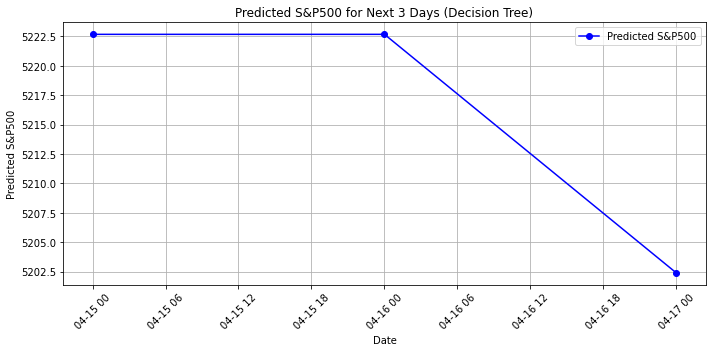

2025-04-15: Predicted S&P500 = 5222.68
2025-04-16: Predicted S&P500 = 5222.68
2025-04-17: Predicted S&P500 = 5202.39


In [47]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

n_future = 3
last_known = data_set.iloc[-1].copy()
future_dates = []
predictions = []
future_rows = []

start_date = datetime.date.today() + datetime.timedelta(days=1)

def uptrend(x, step=0.002, noise_scale=0.001):
    trend = x * (1 + step)
    noise = x * np.random.normal(0, noise_scale)
    return trend + noise

for i in range(n_future):
    future_date = start_date + datetime.timedelta(days=i)
    future_dates.append(future_date)
    
    input_dict = {
        'Date': int(datetime.datetime.combine(future_date, datetime.time()).timestamp()),
        'SP500': last_known['SP500'],
        'Futures': last_known['Futures'],
        'Nikkei': last_known['Nikkei'],
        'FTSE': last_known['FTSE'],
        'DAX': last_known['DAX'],
        'SP500_lag_1': last_known['SP500_lag_1'],
        'SP500_lag_2': last_known['SP500_lag_2'],
        'SP500_lag_3': last_known['SP500_lag_3'],
        'DAX_lag_1': last_known['DAX_lag_1'],
        'DAX_lag_2': last_known['DAX_lag_2'],
        'DAX_lag_3': last_known['DAX_lag_3'],
        'FTSE_lag_1': last_known['FTSE_lag_1'],
        'FTSE_lag_2': last_known['FTSE_lag_2'],
        'FTSE_lag_3': last_known['FTSE_lag_3'],
        'Nikkei_lag_1': last_known['Nikkei_lag_1'],
        'Nikkei_lag_2': last_known['Nikkei_lag_2'],
        'Nikkei_lag_3': last_known['Nikkei_lag_3']
    }
    
    input_dict.update(generate_day_of_week_features(future_date))
    input_df = pd.DataFrame([input_dict])

    # Align with clf (DecisionTree) training features
    required_features = clf.feature_names_in_
    for col in required_features:
        if col not in input_df.columns:
            input_df[col] = 0.0
    input_df = input_df[required_features]

    # Predict using Decision Tree
    pred = clf.predict(input_df)[0]
    predictions.append(pred)

    # Update last_known for next day's prediction
    new_row = last_known.copy()
    new_row['SP500'] = pred
    new_row['SP500_lag_3'] = new_row['SP500_lag_2']
    new_row['SP500_lag_2'] = new_row['SP500_lag_1']
    new_row['SP500_lag_1'] = pred

    for col in ['Futures', 'Nikkei', 'FTSE', 'DAX']:
        new_row[col] = uptrend(last_known[col])

    for col in ['DAX', 'FTSE', 'Nikkei']:
        for lag in [3, 2, 1]:
            new_row[f'{col}_lag_{lag}'] = new_row[col]

    new_row['Date'] = int(datetime.datetime.combine(future_date, datetime.time()).timestamp())
    future_rows.append(new_row)
    last_known = new_row

# Plot
plt.figure(figsize=(10, 5))
plt.plot(future_dates, predictions, marker='o', linestyle='-', color='blue', label='Predicted S&P500')
plt.title('Predicted S&P500 for Next 3 Days (Decision Tree)')
plt.xlabel('Date')
plt.ylabel('Predicted S&P500')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print predictions
for date, price in zip(future_dates, predictions):
    print(f"{date}: Predicted S&P500 = {price:.2f}")


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'S&P500 Prediction for Next 3 Days (Linear + RF Residual)')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Predicted S&P500')

(array([20193.  , 20193.25, 20193.5 , 20193.75, 20194.  , 20194.25,
        20194.5 , 20194.75, 20195.  ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

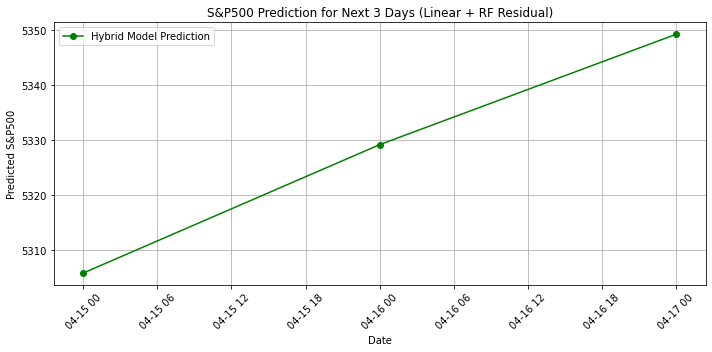

2025-04-15: Predicted S&P500 = 5305.78
2025-04-16: Predicted S&P500 = 5329.14
2025-04-17: Predicted S&P500 = 5349.21


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Start from the last known row of your data
last_known = data_set.iloc[-1].copy()
predictions = []
future_dates = []
future_rows = []
n_future = 3

# Starting from tomorrow
start_date = datetime.date.today() + datetime.timedelta(days=1)

def uptrend(x, step=0.002, noise_scale=0.001):
    trend = x * (1 + step)
    noise = x * np.random.normal(0, noise_scale)
    return trend + noise

for i in range(n_future):
    future_date = start_date + datetime.timedelta(days=i)
    future_dates.append(future_date)
    
    input_dict = {
        'Date': int(datetime.datetime.combine(future_date, datetime.time()).timestamp()),
        'SP500': last_known['SP500'],
        'Futures': last_known['Futures'],
        'Nikkei': last_known['Nikkei'],
        'FTSE': last_known['FTSE'],
        'DAX': last_known['DAX'],
        'SP500_lag_1': last_known['SP500_lag_1'],
        'SP500_lag_2': last_known['SP500_lag_2'],
        'SP500_lag_3': last_known['SP500_lag_3'],
        'DAX_lag_1': last_known['DAX_lag_1'],
        'DAX_lag_2': last_known['DAX_lag_2'],
        'DAX_lag_3': last_known['DAX_lag_3'],
        'FTSE_lag_1': last_known['FTSE_lag_1'],
        'FTSE_lag_2': last_known['FTSE_lag_2'],
        'FTSE_lag_3': last_known['FTSE_lag_3'],
        'Nikkei_lag_1': last_known['Nikkei_lag_1'],
        'Nikkei_lag_2': last_known['Nikkei_lag_2'],
        'Nikkei_lag_3': last_known['Nikkei_lag_3']
    }
    
    input_dict.update(generate_day_of_week_features(future_date))
    input_df = pd.DataFrame([input_dict])
    
    # Ensure correct feature order
    required_features = model.feature_names_in_
    for col in required_features:
        if col not in input_df.columns:
            input_df[col] = 0.0
    input_df = input_df[required_features]

    # 💡 Hybrid Prediction = Linear + RF Residual
    linear_pred = model.predict(input_df)[0]
    residual_pred = rf.predict(input_df)[0]
    hybrid_pred = linear_pred + residual_pred

    predictions.append(hybrid_pred)

    # Update for next prediction
    new_row = last_known.copy()
    new_row['SP500'] = hybrid_pred
    new_row['SP500_lag_3'] = new_row['SP500_lag_2']
    new_row['SP500_lag_2'] = new_row['SP500_lag_1']
    new_row['SP500_lag_1'] = hybrid_pred

    for col in ['Futures', 'Nikkei', 'FTSE', 'DAX']:
        new_row[col] = uptrend(last_known[col])

    for col in ['DAX', 'FTSE', 'Nikkei']:
        for lag in [3, 2, 1]:
            new_row[f'{col}_lag_{lag}'] = new_row[col]

    new_row['Date'] = int(datetime.datetime.combine(future_date, datetime.time()).timestamp())
    future_rows.append(new_row)
    last_known = new_row

# Plot
plt.figure(figsize=(10, 5))
plt.plot(future_dates, predictions, marker='o', linestyle='-', color='green', label='Hybrid Model Prediction')
plt.title('S&P500 Prediction for Next 3 Days (Linear + RF Residual)')
plt.xlabel('Date')
plt.ylabel('Predicted S&P500')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print forecasted values
for date, price in zip(future_dates, predictions):
    print(f"{date}: Predicted S&P500 = {price:.2f}")
